### 读取时间序列TIF | Read time-series TIF files

In [ ]:
import os
import random
from glob import glob
from osgeo import gdal
import numpy as np
from tqdm import tqdm
from datetime import datetime


def imread(tif_file):
    return gdal.Open(tif_file).ReadAsArray()

site = "Germany"
main_folder = "../dataset/dataset_down_from_GEE/"
hdf_folder = "../dataset/dataset_for_model/"

In [2]:
tif_list = glob(main_folder + site + '/S2_remove_cloud/*.tif')
s2_array = []
cloud_mask_array = []
date_list = []

no_cloud_percents = []
valiad_num = 0
non_valiad_num = 0
for tif in tqdm(tif_list):
    s2 = imread(tif)
    s2_array.append(s2)

    date = os.path.basename(tif).split('_')[-1]
    date_list.append(date.split(".")[0])
    
    cloud_mask_temp = s2[0, :, :] != 0 # 0 is missing, 1 is valid
    cloud_mask_temp = np.repeat(cloud_mask_temp[np.newaxis, :, :], 10, axis=0)
    cloud_mask_array.append(cloud_mask_temp.astype(np.uint8))
    
    valiad_num_temp = np.sum(s2[0, :, :] != 0)
    valiad_num += valiad_num_temp
    no_cloud_percents.append(valiad_num_temp / (s2.shape[1]*s2.shape[2]))
    non_valiad_num += np.sum(s2[0, :, :] == 0)
    
s2_array = np.stack(s2_array)    
t, b, h, w = s2_array.shape
s2_array = s2_array.reshape(t, b, -1)

cloud_mask_array = np.stack(cloud_mask_array)
cloud_mask_array = cloud_mask_array.reshape(t, b, -1) # 0 is missing, 1 is valid

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [01:16<00:00,  1.41s/it]


In [ ]:
valiad_num_for_series = valiad_num / (t*h*w)
print("整个序列的有效像素占比 | Percentage of clear pixels in the entire sequence:{}".format(valiad_num_for_series))

def int_to_doy(date_int):
    date_str = str(date_int)
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])     
    date_obj = datetime(year, month, day)  
    doy = date_obj.timetuple().tm_yday
    return doy

doy_list = np.asarray([int_to_doy(d) for d in date_list])
print("保留影像的年积日 | DOYs in Preserved Images:\n{}".format(doy_list))

整个序列的有效像素占比:0.688164618690393
保留影像的年积日:
[ 39  47  49  59  64  79  82  89  92  94  97  99 107 109 112 114 127 132
 137 144 149 152 154 157 159 162 169 174 177 182 192 199 202 204 207 209
 222 234 237 239 244 247 249 254 257 259 262 264 269 279 287 339 344 354]


### 写出HDF数据 | extract them into HDF format

In [ ]:
import h5py

hdf_save_path = os.path.join(hdf_folder, site, "hdf", "anytime.hdf")
with h5py.File(hdf_save_path, "w") as hf:
    X_set = hf.create_group("data")
    # timelen, featuresnum, sample number → sample number, timelen, feature_num
    X_set.create_dataset("X", data = s2_array.astype(np.uint16).transpose(2, 0, 1), compression='gzip', compression_opts=9)
    X_set.create_dataset("date", data = doy_list.astype(np.uint16), compression='gzip', compression_opts=9)
    
    mask_set = hf.create_group("mask")

### 虽然缺失比例设置为40%，只是为了和之前随机缺失数据IO兼容 | Although the missing proportion is set to 40%, this is solely for compatibility with previous random missing data I/O.

In [ ]:
# 通过为序列中剩余单景清晰像素影像应用云掩膜, 模拟不同比率的云覆盖
# Simulate varying degrees of cloud cover by applying cloud masks to the remaining clear-pixel imagery in the sequence.
random.seed(66)
np.random.seed(66)
novalid_percents = ["40%"]
candidate_cloud_masks = [0]

for cloud_mask_artifical, flag in zip(candidate_cloud_masks, novalid_percents):
    
    missing_mask_temp = cloud_mask_array.copy() # 1 表示有效观测 | 1s represent clear pixel
    # Anytime mode 使用清晰像素的reconstruction MAE作为保存checkpoint的依据 | 2026-01-13修复
    indicating_mask_temp = cloud_mask_array.copy() # 1 代表保留验证; 即等于人工添加云的像素 | 1 represents the pixel that was held for testing.
    
    with h5py.File(hdf_save_path, "a") as hf:
        mask_set = hf.require_group("mask")
        mask_set.create_dataset("missing_mask_" + flag, data=missing_mask_temp.astype(np.uint8).transpose(2, 0, 1), compression='gzip', compression_opts=9)
        mask_set.create_dataset("indicating_mask_" + flag, data=indicating_mask_temp.astype(np.uint8).transpose(2, 0, 1), compression='gzip', compression_opts=9)

### 提取SAR时间序列为HDF | Extract SAR time series into HDF

In [ ]:
import os
from glob import glob
from osgeo import gdal # type: ignore
import numpy as np # type: ignore
from tqdm import tqdm # type: ignore
from datetime import datetime
import h5py # type: ignore


def imread(tif_file):
    return gdal.Open(tif_file).ReadAsArray()

S1_folder = os.path.join(main_folder, site, "S1_raw")

In [ ]:
def int_to_doy(date_int):
    date_str = str(date_int)
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])     
    date_obj = datetime(year, month, day)  
    doy = date_obj.timetuple().tm_yday
    return doy


tif_list = glob(S1_folder + '/*.tif')
s1_array = []
date_list = []
for tif in tqdm(tif_list):
    s1 = imread(tif)
    valiad_percent = np.sum(~np.isnan(s1[0, :, :])) / 1501**2
    if valiad_percent > 0.9:
        # print(os.path.basename(tif), valiad_percent)
        s1_array.append(s1)
        
        date = os.path.basename(tif).split('_')[-1]
        date_list.append(date.split(".")[0])

s1_array = np.stack(s1_array)    
t, b, h, w = s1_array.shape
s1_array = s1_array.reshape(t, b, -1)

date_list = np.asarray([int_to_doy(d) for d in date_list])
print("有效SAR影像的年积日 | DOYs of Valid SAR Imagery:\n{}".format(date_list))

100%|██████████| 120/120 [00:26<00:00,  4.51it/s]


有效SAR影像的年积日:
[  1   6   7  12  13  18  19  24  25  30  31  36  37  42  43  48  49  54
  55  60  61  66  67  72  73  78  79  84  85  90  91  96  97 102 103 109
 114 115 120 121 126 127 132 133 138 139 144 145 150 151 156 157 162 163
 168 169 174 175 180 181 186 187 192 193 198 199 204 205 210 211 216 217
 222 223 228 229 234 235 240 241 246 247 252 253 258 259 264 265 270 271
 276 277 282 283 288 289 294 295 300 301 306 307 312 313 318 319 324 325
 330 331 336 337 342 343 348 349 354 355 360 361]


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
s1_array_ = s1_array.transpose(1, 0, 2).reshape(2, -1).transpose(1, 0)

s1_array_[np.isnan(s1_array_)] = np.nanmean(s1_array_)
scaler.fit(s1_array_)

mean = scaler.mean_
std = scaler.scale_
print(mean)
print(std)

[-10.58998404 -17.8438248 ]
[3.18391555 4.17189133]


In [9]:
with h5py.File(hdf_save_path, "a") as hf:
    group = hf.require_group('data')
    
    group.create_dataset("X_aux", data = s1_array.astype(np.float32).transpose(2, 0, 1), compression='gzip', compression_opts=9)
    group.create_dataset("date_aux", data = date_list.astype(np.uint16), compression='gzip', compression_opts=9)
    
    group.create_dataset("X_aux_mean", data = mean.astype(np.float32), compression='gzip', compression_opts=9)
    group.create_dataset("X_aux_std", data = std.astype(np.float32), compression='gzip', compression_opts=9)

### 验证HDF数据并写入均值标准差 | Verify HDF data and write mean and Standard Deviation

In [11]:
'''
data
    - X
    - date
    - X_aux
    - date_aux
    - X_aux_mean
    - X_aux_std
mask
    - missing_mask_80%
    - indicating_mask_80%
    - missing_mask_40%
    - indicating_mask_40%
    - missing_mask_40%
    - indicating_mask_40%    
'''
import h5py # type: ignore

with h5py.File(hdf_save_path, "r") as hf:
    missing_mask_40 = hf["mask"]["missing_mask_40%"][:]

    m40 = np.sum(missing_mask_40) / missing_mask_40.size
    print("有效占比{}".format(m40))
    
    indicating_mask_40 = hf["mask"]["indicating_mask_40%"][:]
    
    i40 = np.sum(indicating_mask_40) / indicating_mask_40.size
    
    print("保留验证像素占比{}".format(i40))

有效占比0.688164618690393
保留验证像素占比1.0


In [ ]:
def cal_mean_std(X, mask):
    X = X.astype(np.float64) / 10000
    X[mask==0] = np.nan
    
    from einops import rearrange # type: ignore
    X = rearrange(X, "n t b -> b (n t)")
    X = rearrange(X, "b nt -> nt b")
    X_mean = np.nanmean(X, axis=0) 
    X_std = np.nanstd(X, axis=0)
    return X_mean[np.newaxis, :], X_std[np.newaxis, :]


with h5py.File(hdf_save_path, "a") as hf:
    X = hf["data"]["X"][:]
    group = hf.require_group('data')
    
    X_mean_40, X_std_40 = cal_mean_std(X, missing_mask_40)
    
    group.create_dataset("X_mean_40%", data = X_mean_40.astype(np.float32))
    group.create_dataset("X_std_40%", data = X_std_40.astype(np.float32))

    print("mean, std of 40%: {X_mean_40} {X_std_40}}".format(
        X_mean_40=X_mean_40, 
        X_std_40=X_std_40, 
    ))

KeyError: 'X_mean_60'

#### 验证写入的均值和标准差 | Verifying Mean and Standard Deviation

In [ ]:
with h5py.File(hdf_save_path, "a") as hf:
    X_mean_40, X_std_40 = hf["data"]["X_mean_40%"][:], hf["data"]["X_std_40%"][:]
    
    print("mean, std of 40%: {X_mean_40} {X_std_40}".format(
        X_mean_40=X_mean_40, 
        X_std_40=X_std_40, 
    ))

mean, std of 40%: [[0.05543235 0.07758724 0.07805622 0.1215065  0.2275884  0.26581228
  0.28235465 0.2887931  0.21042383 0.14653753]] [[0.03008154 0.03668859 0.05448204 0.05386765 0.06874312 0.08508624
  0.08932689 0.08611836 0.09272064 0.09553504]]


#### missing plot

[296994]


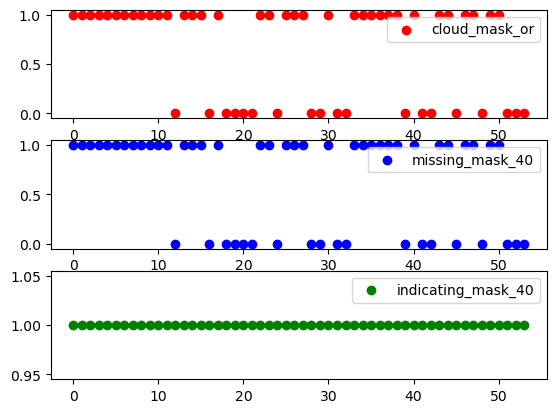

In [15]:
import matplotlib.pyplot as plt
idx = random.sample(range(0, len(missing_mask_40)), 1)
print(idx)
t = missing_mask_40.shape[1]

cloud_mask_or = cloud_mask_array.transpose(2, 0, 1)[idx, :, 0]
missing_mask_40_ = missing_mask_40[idx, :, 0]
indicating_mask_40_ = indicating_mask_40[idx, :, 0]

fig, axs = plt.subplots(3)
axs[0].scatter(np.arange(t), cloud_mask_or, c='r', label='cloud_mask_or') # 1 表示有效观测
axs[1].scatter(np.arange(t), missing_mask_40_, c='b', label='missing_mask_40') # 1 表示有效观测
axs[2].scatter(np.arange(t), indicating_mask_40_, c='g', label='indicating_mask_40') # 1 表示保留验证
axs[0].legend()
axs[1].legend()
axs[2].legend()